# Computer Vision Case Study: Creating an Application


### What did we learn about our application?

* Image Capture
    * Reduce glare from the blue leds
    * Increase exposure
    * Video Feed?
    
    
* Image Processing Steps (and parameters)
    * read image (filepath)
    * view image
    * crop (slice, slice)
    * separate channels
    * combine channels to isolate green flourescent particles (weights + offset)
    * histogram equalization
    * Gaussian filtering (kernel size?)
    * histogram equalization
    * Otsu threshold
    * morphological closing (kernel?, iterations?)
    * morphological opening (kernel?, iterations?)
    * labeling (structure?)
    * display labels and particle count
    

## Test Driven Development, or *Festina Lente* ("make haste, slowly")

Our goal is to create a Python module for particle labeling and counting. We anticipate testing the approach using representative images taken under different conditions, then embedding the code into a user application, perhaps with a GUI interface, running on a microcontroller with integrated camera.

For these purposes, we will create several Python classes to streamline the workflow. It's important for the workflow to be flexible and adaptable to accomodate experimentation. 

**Test Driven Development**

We'll simultaneously writing test code to verify that our classes correctly implement steps in the workflow. Test driven development is a techique where units tests are written to guide code development. Test driven development is normally done in Python IDEs with formal software tools for unit testing, but the core principals can also be applied to smaller research projects created in Jupyter notebooks. 

The process for code development organized as follows:

* Write a unit test for a needed feature.
* Write the minimal code needed to pass the unit test.
* Simplify the code
* Repeat with the next feature

**Unit Test**

Unit tests are code that tests the function the smallest piece of code that can be logically isolated in a larger system. There are software tools specifically designed to support unit testing of Python modules. We can also create simple tests using Python's builtin ``assert`` statement.

Remember:

1. Untested code is broken code.
2. Don't waste your time writing untested code.

**Simplicity Critera**

* All code must pass all tests.
* Avoid code duplication. That is, there should be no code sequence that appears more than once. Duplicated code should be replaced by a function, class, or method.
* Each distinct idea, feature, or function should separately expressed in the code.
* Keep the number classes, methods, and lines of code to a minimum.

### Labeler Class

The Labeler class will be the primary interface to the application. When working from the Python console, the user use Labeler class to create labelers that locate and label particles in one or more images. Typical usage would be

    labeler = Labeler(parameter1, parameter2, ...)
    
where parameters specify the workflow that will be used. Once created, a typical use of labeler would be might be as follows:

    labeler.read(filepath)
    labeler.show(ax)
    
Note that we pass an plotting axis to the ``.show()`` class method. This allows the application to control plotting and layouts, and simplifies the ``Labeler`` class.

Let's start by creating a cell that would test these features.

In [2]:
# restart the kernel before executing this cell

# coding section


# testing section
import glob

# labeler instance
labeler = Labeler(1, 2, 3)
assert isinstance(labeler, Labeler)

# open test images
for filepath in glob.glob('./data/25-*'):
    labeler.read(filepath)
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    labeler.show(ax)

NameError: name 'Labeler' is not defined

**Exercise**

Before going further, attempt to write some Python code that successfully passes the tests in the cell above.

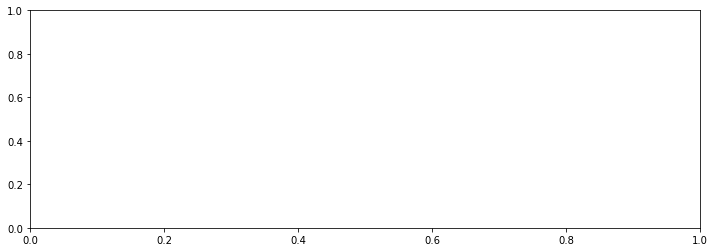

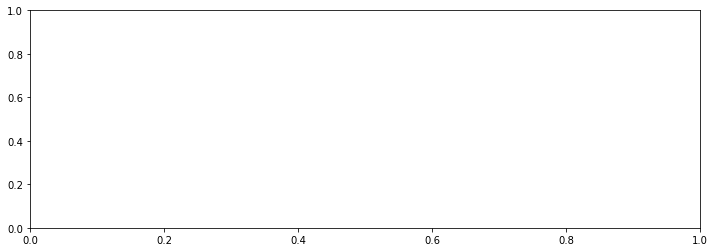

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

class Labeler():
    
    def __init__(self, *args):
        pass
    
    def read(self, filepath):
        pass
    
    def show(self, ax):
        pass

# testing section
import glob

# labeler instance
labeler = Labeler(1, 2, 3)
assert isinstance(labeler, Labeler)

# open test images
for filepath in glob.glob('./data/25-*'):
    labeler.read(filepath)
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    labeler.show(ax)

### Loading image files

We will read files in RGB format and convert to numpy ndarray. We'll create tests that verify the images are correctly load, and then write code until the tests succeed. We will save the filepath to label plots, and save the image data as a NumPy array in RGB format.

Note that in this cell we cheat a bit on TDD, doing a bit of iteration between the tests and application code. The goal is to end up the desired features and test code that completely covers the application code.

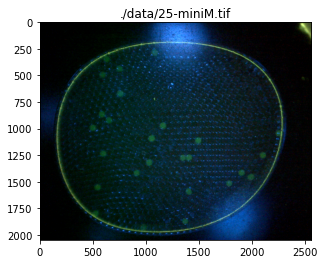

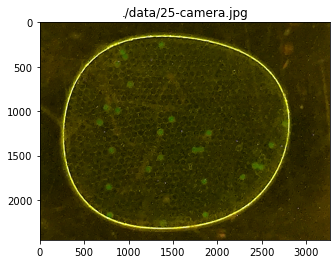

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

class Labeler():
    
    def __init__(self, *args):
        pass
    
    def read(self, filepath):
        self.filepath = filepath
        self.img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    
    def show(self, ax):
        ax.imshow(self.img)
        ax.set_title(self.filepath)


# testing section
import glob

# labeler instance
labeler = Labeler(1, 2, 3)
assert isinstance(labeler, Labeler)

# open test images
for filepath in glob.glob('./data/25-*'):
    labeler.read(filepath)
    assert labeler.filepath == filepath
    assert isinstance(labeler.img, np.ndarray)
    assert labeler.img.ndim == 3
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    labeler.show(ax)
    assert plt.gca() == ax
    assert plt.gca().get_title() == labeler.filepath

### Image Rescaling and Cropping

The test images show the images appear with different sizes, and extraneous information at the boundaries.  In this cell we add functions to rescale and crop the image. The display is changed to more clearly label the coordinate system. The Python native ``slice()`` function is used to specify the crop.

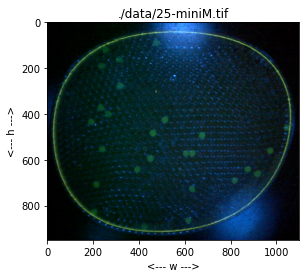

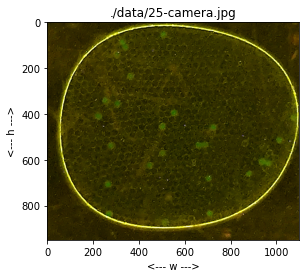

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

class Labeler():
    
    def __init__(self, *args):
        pass
    
    def read(self, filepath):
        self.filepath = filepath
        self.img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
        
    def rescale(self, size = 1000):
        h, w, d = self.img.shape
        sf = max(size/h, size/w)
        self.img = cv2.resize(self.img, None, fx=sf, fy=sf)
        
    def crop(self, scale_h, scale_w):
        self.img = self.img[scale_h, scale_w]
    
    def show(self, ax):
        ax.imshow(self.img)
        ax.set_title(self.filepath)
        ax.set_xlabel("<--- w --->")
        ax.set_ylabel("<--- h --->")

        
# testing section
import glob

# labeler instance
labeler = Labeler(1, 2, 3)
assert isinstance(labeler, Labeler)

# open test images
for filepath in glob.glob('./data/25-*'):
    
    # read tests
    labeler.read(filepath)
    assert labeler.filepath == filepath
    assert isinstance(labeler.img, np.ndarray)
    assert labeler.img.ndim == 3
    
    # rescale tests
    H = 1000
    labeler.rescale(H)
    h, w, d = labeler.img.shape
    assert min([h, w]) == H
    assert d == 3
    
    # crop tests
    labeler.crop(slice(50, 1000, 1), slice(50, 1150, 1))
    h, w, d = labeler.img.shape
    assert h == 1000 - 50
    assert w == 1150 - 50
    assert d == 3
    
    # show tests
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    labeler.show(ax)
    assert plt.gca() == ax
    assert plt.gca().get_title() == labeler.filepath
    assert len(plt.gca().get_xlabel()) > 0
    assert len(plt.gca().get_ylabel()) > 0

### Channel Class

The next steps of the workflow involve the creation of new images through affine combination of the image channels and various filtering and morphological transformations. For this purpose we create a ``Channel`` class to represent these derivative images. We will assume

* Channels have the same height and width as the images from which they are derived.


The next step in the workflow is to separate the image into channels. We will implement a channel as a two dimensional NumPy array with same height and width as the rescaled and cropped image. The data entries are eight bit unsigned integers One extra consideration is that we need additional channels to store intermediate results.

In the next cell we'll create a Channel class. Later we will integrate Channel class into the main Labeler application. 

What we seek is a Channel class where

    channel = Channel()              # create Channel object with empty channel data
    channel = Channel(img_2Ddata)    # create Channel object from 2D numpy channel data
    channel.histogram                # return histogram
    channel.show(ax)                 # show the channel on a specified axis
    channel.show_histogram(ax)       # show the histogram on a specified axis
    
It will sometimes be helpful to display a channel with additional color information, particularly with regard to showing multiple histograms on a single axis. For this reason we also desire the following features:

    channel.show(ax, color)            # show the channel on a specified axis
    channel.show_histogram(ax, color)  # show the histogram on a specified axis
    
where ``color`` is one of "k", "r", "g", or "b".

We will need to access the image data from a channel. To facilitate access, and to hide details of how the image data is stored inside the class, we let

    channel()                          # return image data as a NumPy array
    
The testing goal is to provide complete coverage of the Channel class.

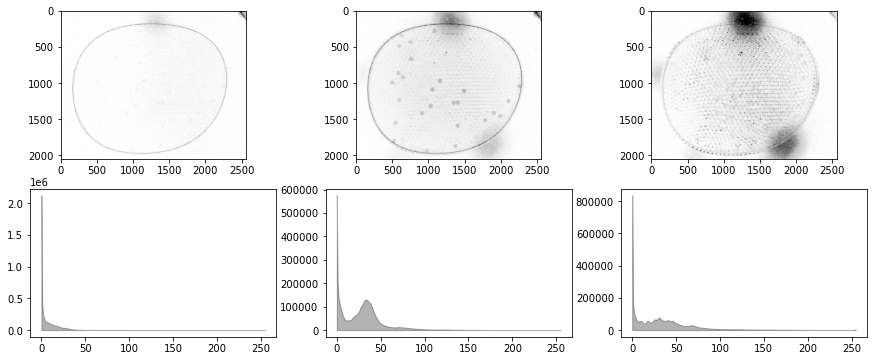

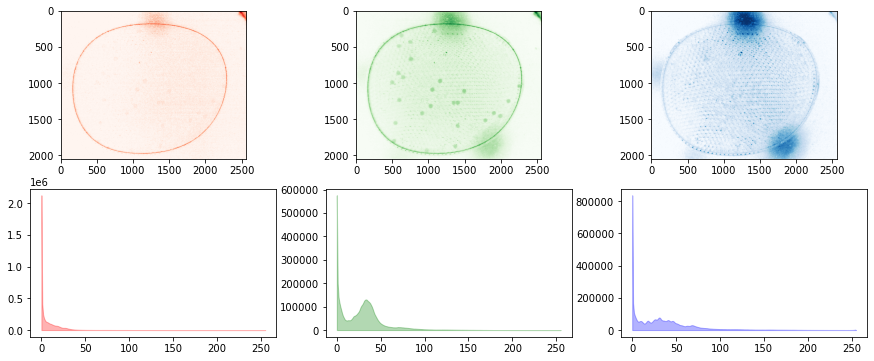

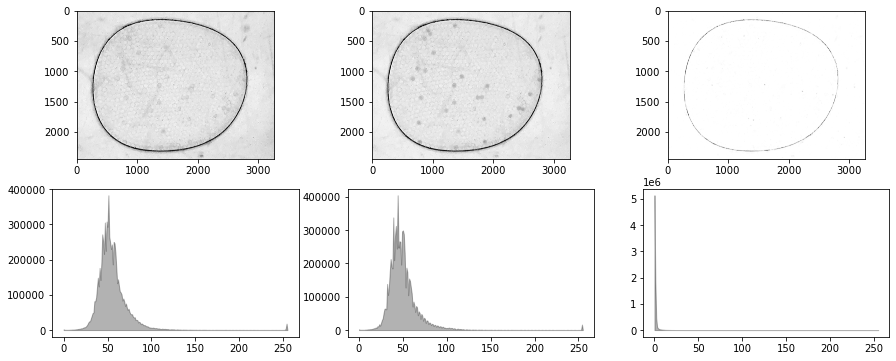

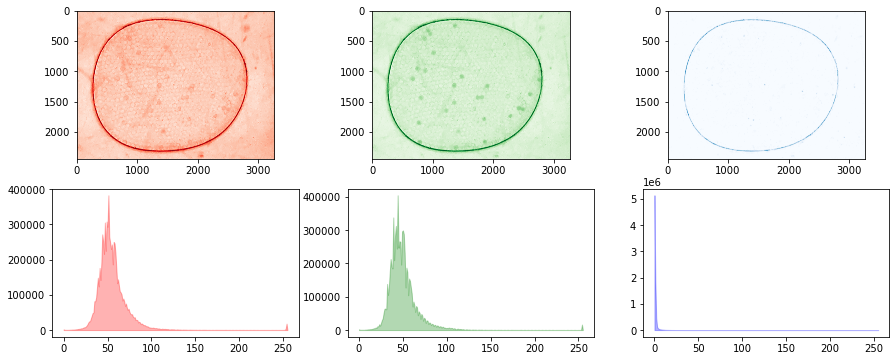

In [165]:
class Channel():
    
    colormaps = {"k":"Greys", "r":"Reds", "g":"Greens", "b":"Blues"}
    
    def __init__(self, data=None):
        if data is None:
            self.data = np.zeros((0,0), dtype=np.uint8)
        else:
            self.data = data.astype(np.uint8)
        
    def __call__(self, data=None):
        """"Set and return current channel data."""
        if not (data is None):
            self.data = data.astype(np.uint8)
        return self.data

    @property
    def histogram(self):
        return cv2.calcHist([self.data], [0], None, [256], [0, 255]).flatten()
    
    def show(self, ax, color='k'):
        ax.imshow(self.data, cmap=self.colormaps[color])
        
    def show_histogram(self, ax, color='k'):
        bins = np.arange(0, 256)
        ax.fill_between(bins, self.histogram, 0, color=color, alpha=0.3)
        
        
# testing code
for filepath in glob.glob("./data/25-*"):
    
    # create test data
    img = cv2.imread(filepath)
    b, g, r = cv2.split(img)
    
    # test instance creation with and without data
    channel = Channel()
    assert isinstance(channel, Channel)
    channel = Channel(r)
    assert isinstance(channel, Channel)
    assert np.all(channel() == r)
        
    # set and get channel data from instance
    channel = Channel()
    for data in [r, g, b]:
        channel(data)
        assert isinstance(channel(), np.ndarray)
        assert np.all(channel() == data), f"{filepath}"
        
    # test histogram
    channel = Channel()
    for data in [r, g, b]:
        channel(data)
        assert isinstance(channel.histogram, np.ndarray)
        assert channel.histogram.dtype == 'float32'
        assert len(channel.histogram) == 256
        assert np.all(channel.histogram >= 0)
        
    # test show and show_histogram with default color
    fig, ax = plt.subplots(2, 3, figsize=(15, 6))
    for i, data in enumerate([r, g, b]):
        channel(data)
        channel.show(ax[0, i])  
        channel.show_histogram(ax[1, i])
    
    # test show and show_histogram with optional color
    fig, ax = plt.subplots(2, 3, figsize=(15, 6))
    colors = ['r', 'g', 'b']
    for i, data in enumerate([r, g, b]):
        channel(data)
        channel.show(ax[0, i], color=colors[i])  
        channel.show_histogram(ax[1, i], color=colors[i])

### Integrating Channels into Labeler

Next we use the Channels object inside Labeler. The functionality we seek is to create channels from the core image. A channel is create upon first reference. For example, to create a gray scalel approximation to the reference image.

    r, g, b = labeler.img
    labeler.channels['k']((r + g + b)/3)

Data from the channel is accessed by a function call to the instance.

    bw = labeler.channels['k']()

./data/25-miniM.tif
./data/25-camera.jpg


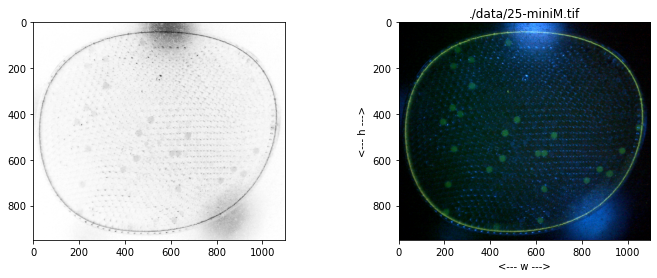

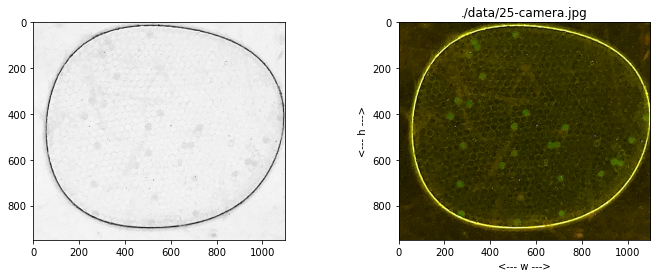

In [232]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict

class Labeler():
    
    def __init__(self, *args):
        self.channels = defaultdict(Channel)
    
    def read(self, filepath):
        self.filepath = filepath
        self.img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
        
    def rescale(self, size = 1000):
        h, w, d = self.img.shape
        sf = max(size/h, size/w)
        self.img = cv2.resize(self.img, None, fx=sf, fy=sf)
        
    def crop(self, scale_h, scale_w):
        self.img = self.img[scale_h, scale_w]
    
    def show(self, ax):
        ax.imshow(self.img)
        ax.set_title(self.filepath)
        ax.set_xlabel("<--- w --->")
        ax.set_ylabel("<--- h --->")

        
# testing section
import glob

# instance tests
labeler = Labeler()
assert isinstance(labeler, Labeler)
assert isinstance(labeler.channels, dict)

# open test images
for filepath in glob.glob('./data/25-*'):
    
    # read tests
    labeler.read(filepath)
    assert labeler.filepath == filepath
    assert isinstance(labeler.img, np.ndarray)
    assert labeler.img.ndim == 3
    print(filepath)
    
    # rescale tests
    H = 1000
    labeler.rescale(H)
    h, w, d = labeler.img.shape
    assert min([h, w]) == H
    assert d == 3
    
    # crop tests
    labeler.crop(slice(50, 1000, 1), slice(50, 1150, 1))
    h, w, d = labeler.img.shape
    assert h == 1000 - 50
    assert w == 1150 - 50
    assert d == 3
    
    # create_channel tests
    weights = np.array([1, 1, 1])/3
    offset = 0
    
    labeler.channels['k'](np.dot(labeler.img, weights) + offset)
    assert labeler.channels['k'].data.ndim == 2
    assert np.all(labeler.channels['k'].data >= 0)
    assert np.all(labeler.channels['k'].data <= 255)
    assert labeler.channels['k'].data.dtype == np.uint8
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    labeler.channels['k'].show(ax[0])
    
    # show tests
    labeler.show(ax[1])
    assert plt.gca() == ax[1]
    assert plt.gca().get_title() == labeler.filepath
    assert len(plt.gca().get_xlabel()) > 0
    assert len(plt.gca().get_ylabel()) > 0

### Additional Channel Methods

Most of the processing work will be done with Channels. Following the experimental explorations, at a minimum we know we'll need 

* treshhold
* histogram equalization
* Gaussian blur
* morphological close
* morphological open
* labeling
* find particles

We cut and past the prior Channel class, create tests, then code the corresponding methods.

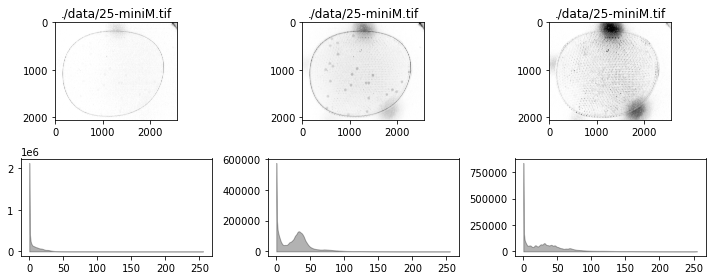

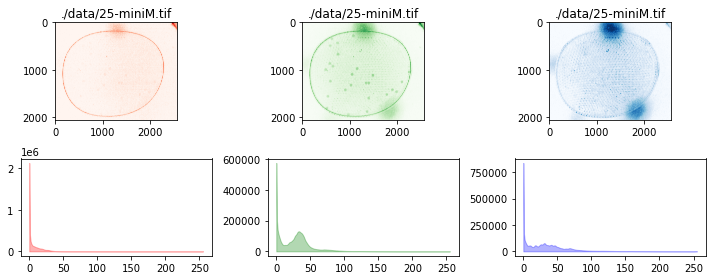

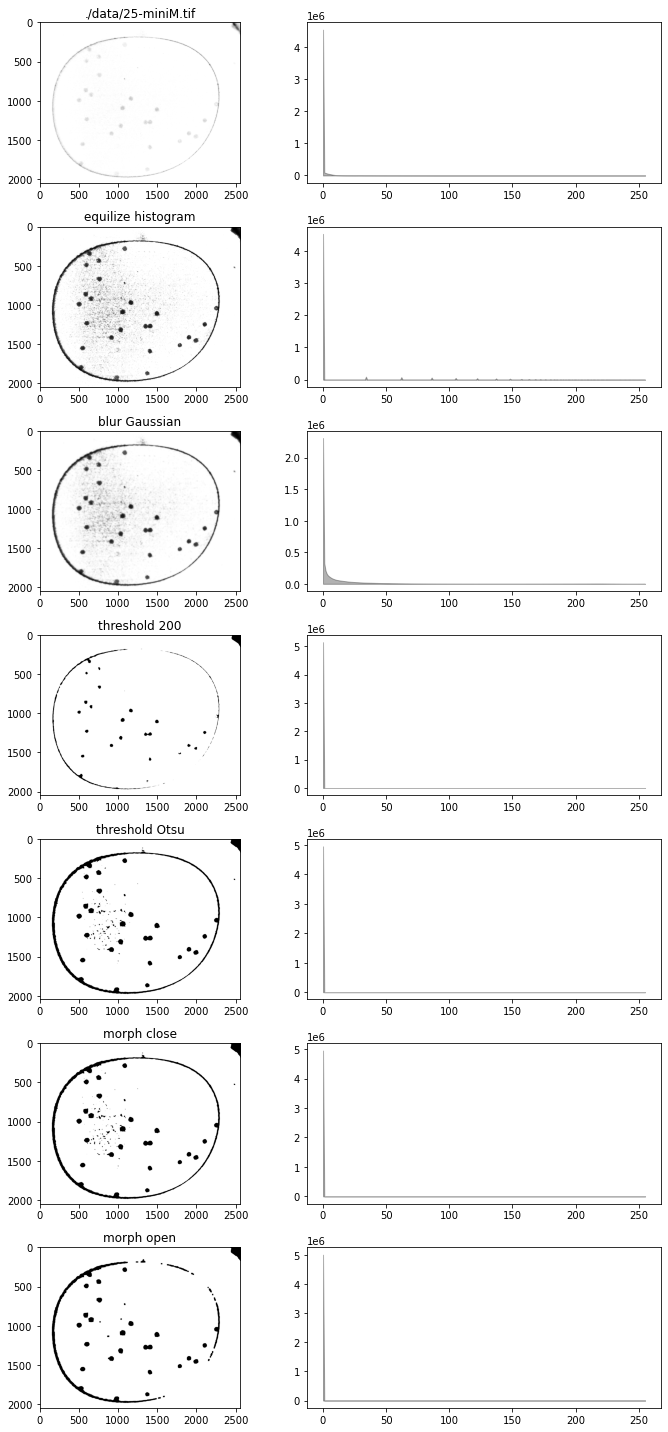

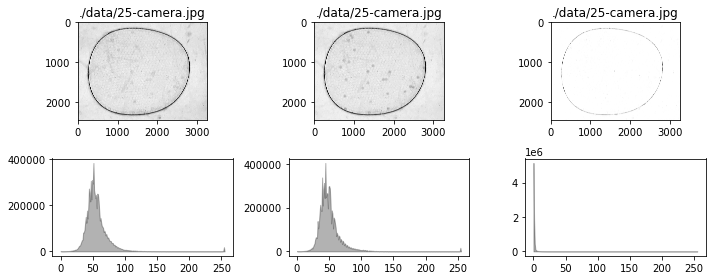

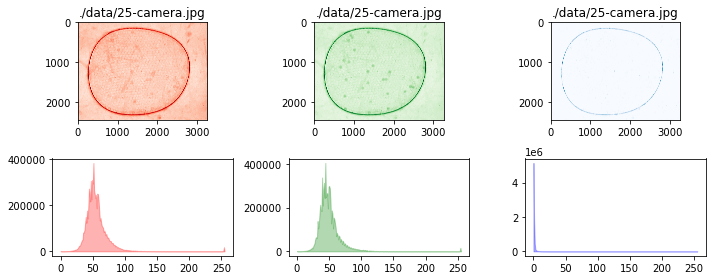

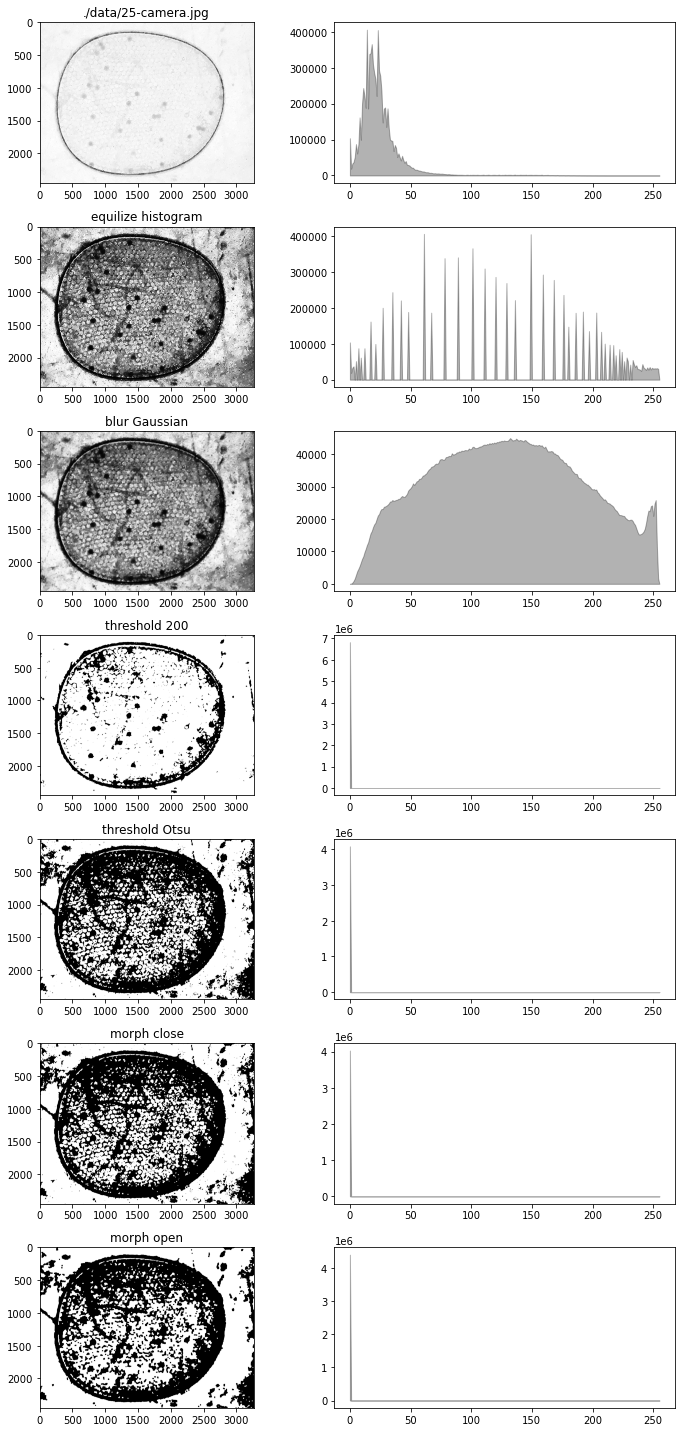

In [263]:
class Channel():
    
    colormaps = {"k":"Greys", "r":"Reds", "g":"Greens", "b":"Blues"}
    
    def __init__(self, data=None):
        if data is None:
            self.data = np.zeros((0,0), dtype=np.uint8)
        else:
            self.data = self.import_array(data)
        
    def __call__(self, data=None):
        """"Set and return current channel data."""
        if not (data is None):
            self.data = self.import_array(data)
        return self.data
    
    def import_array(self, data):
        data = np.where(data < 0, 0, data)
        data = np.where(data > 255, 255, data)
        return data.astype(np.uint8)

    @property
    def histogram(self):
        return cv2.calcHist([self.data], [0], None, [256], [0, 255]).flatten()
    
    def show(self, ax, color='k'):
        ax.imshow(self.data, cmap=self.colormaps[color])
        
    def show_histogram(self, ax, color='k'):
        bins = np.arange(0, 256)
        ax.fill_between(bins, self.histogram, 0, color=color, alpha=0.3)
        
    def equalize_histogram(self):
        self.data = cv2.equalizeHist(self.data)
    
    def blur_Gaussian(self, ksize=3):
        self.data = cv2.GaussianBlur(self.data, (ksize, ksize), 0)
        
    def threshold(self, T):
        T, self.data = cv2.threshold(self.data, T, 255, cv2.THRESH_BINARY)
        
    def threshold_otsu(self):
        T, self.data = cv2.threshold(self.data, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return T
    
    def morph_close(self, iterations=1, kernel=np.ones((3,3))):
        ret = cv2.dilate(self.data, kernel=kernel, iterations=iterations)
        self.data = cv2.erode(ret, kernel=kernel, iterations=iterations)
    
    def morph_open(self, iterations=1, kernel=np.ones((3,3))):
        ret = cv2.erode(self.data, kernel=kernel, iterations=iterations)
        self.data = cv2.dilate(ret, kernel=kernel, iterations=iterations)

        
# testing code

for filepath in glob.glob("./data/25-*"):
        
    img = cv2.imread(filepath)
    b, g, r = cv2.split(img)
    
    # test __init__ creation without data
    channel = Channel()
    assert isinstance(channel, Channel)
        
    # test __init__  with data
    for data in [r, g, b]:
        channel = Channel(data)
        assert isinstance(channel, Channel)
        assert np.all(channel() == data)
        
    # test __call__ 
    channel = Channel()
    for data in [r, g, b]:
        channel(data)
        assert isinstance(channel(), np.ndarray)
        assert np.all(channel() == data)
        
    # test import_array with floating point and out of range data
    channel = Channel()
    channel(r + 2.0*g - 0.4*b + 12.3)
    assert isinstance(channel(), np.ndarray)
    assert channel.data.dtype == "uint8"
        
    # test histogram
    channel = Channel()
    for data in [r, g, b]:
        channel(data)
        assert isinstance(channel.histogram, np.ndarray)
        assert channel.histogram.dtype == 'float32'
        assert len(channel.histogram) == 256
        assert np.all(channel.histogram >= 0)
        
    # test show and show_histogram with default color
    channel = Channel()
    fig, ax = plt.subplots(2, 3, figsize=(10, 4))
    for i, data in enumerate([r, g, b]):
        channel(data)
        channel.show(ax[0, i])  
        channel.show_histogram(ax[1, i])
        ax[0, i].set_title(filepath)
    fig.tight_layout()
        
    # test show and show_histogram with default color
    channel = Channel()
    fig, ax = plt.subplots(2, 3, figsize=(10, 4))
    colors = ['r', 'g', 'b']
    for i, data in enumerate([r, g, b]):
        channel(data)
        channel.show(ax[0, i], color=colors[i])  
        channel.show_histogram(ax[1, i], color=colors[i])
        ax[0, i].set_title(filepath)
    fig.tight_layout()

    # create some channel data
    bw = g - 0.5*b - 0.1*r - 20.0
    
    fig, ax = plt.subplots(7, 2, figsize=(10, 20))
    
    # test import into channel
    channel(bw)
    channel.show(ax[0, 0])
    channel.show_histogram(ax[0, 1])
    ax[0, 0].set_title(filepath)   
    
    # test equalize_histogram
    channel.equalize_histogram()
    channel.show(ax[1, 0])
    channel.show_histogram(ax[1, 1])
    ax[1, 0].set_title("equilize histogram")

    # test blur_Gaussian
    channel.blur_Gaussian(31)
    channel.show(ax[2, 0])
    channel.show_histogram(ax[2, 1])
    ax[2, 0].set_title("blur Gaussian")

    # test threshold
    T = 200
    data = channel()
    channel.threshold(T)
    channel.show(ax[3, 0])
    channel.show_histogram(ax[3, 1])
    ax[3, 0].set_title(f"threshold {T}")
    
    # test threshold_otsu
    channel(data)
    channel.threshold_otsu()
    channel.show(ax[4, 0])
    channel.show_histogram(ax[4, 1])
    ax[4, 0].set_title("threshold Otsu")
    
    # test morph_close
    channel.morph_close(3)
    channel.show(ax[5, 0])
    channel.show_histogram(ax[5, 1])
    ax[5, 0].set_title("morph close")
    
    # test morph_open
    channel.morph_open(8)
    channel.show(ax[6, 0])
    channel.show_histogram(ax[6, 1])
    ax[6, 0].set_title("morph open")
        
    fig.tight_layout()

## Particle Class

In [1]:
class Particle():
    
    def __init__(self, xa, ya, xb, yb):
        self.bb = [xa, ya, xb, yb]
    
class Channel():
    def __init__(self, data, color):
        self.data = data
        self.h, self.w = data.shape
        self.color = color
        
    def show(self):
        fig, ax = plt.subplots(1, 1)
        ax.imshow(self.data, cmap="gray")
        
    def threshold(self, a, b):
        self.data = np.where(self.data < a, a, self.data)
        self.data = np.where(self.data > b, b, self.data)
        
        
class Labeler():
    def __init__(self, filepath):
        self.filepath = filepath
        self.img_bgr = cv2.imread(filepath)
        b, g, r = cv2.split(self.img_bgr)
        self.b = Channel(b, "b")
        self.g = Channel(g, "g")
        self.r = Channel(r, "r")
    
jpgs = [f for f in os.listdir("data") if "jpg" in f]
print(jpgs)
fnames = ["data/25-miniM.tif", "data/25-camera.jpg"]

lbls = [Labeler(f) for f in jpgs]

for lbl in lbls:
    lbl.b.show()

NameError: name 'os' is not defined

In [23]:
p = Particle(20, 30, 40, 50)
q = Particle(35, 670)

plist = [Particle(x, y) for x,y in zip([1, 3, 4], [20, 30, 40])]
for p in plist:
    print(p.x, p.y)

1 20
3 30
4 40


## Classes

How can we break this application down into classes?

What kinds of coding objects do work with?

Main application class: Labeler

Utility classes
* Image
* Channel
* Particle


## Particle Labeling Classes

To facilitate embedded use in a device, the next step is to consolidate these procedures into a class.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import ndimage


class Channel():
    
    def __init__(self, data):
        self.data = data
    
    @property
    def histogram(self):
        return cv.calcHist([self.img], [0], None, [256], [0, 255])
    
    def imshow(self, ax=None, title=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(self.img, cmap="gray")
        if not title is None:
            ax.set_title(title)
        
    def display_histogram(self, ax, color='k'):
        bins = np.arange(0, 256)
        ax.plot(bins, self.histogram, color=color)
        

class Particle():
    
    def __init__(self, x, y, slice):
        self.x = x
        self.y = y
        self.slice = slice
        a, b = slice
        self.xmin = b.start
        self.ymin = a.start
        self.xmax = b.stop
        self.ymax = a.stop
        
    def size(self):
        return np.sqrt((self.xmax - self.xmin) * (self.ymax - self.ymin))
        
    def bounding_box(self):
        return (self.xmin, self.xmax, self.xmax, self.xmin, self.xmin), \
               (self.ymin, self.ymin, self.ymax, self.ymax, self.ymin)


class ParticleLabeler():
    
    def __init__(self, filepath=None):
        self.filepath = filepath
        self.channels = dict()
        self.particles = list()
        if not filepath is None:
            self.imread(filepath)
            
    @property
    def particle_count(self):
        return len(self.particles)

    def imread(self, filepath):
        """Read image from given filepath."""
        self.filepath = filepath
        b, g, r = cv.split(cv.imread(filepath))
        self.channels['r'] = Channel(r)
        self.channels['g'] = Channel(g)
        self.channels['b'] = Channel(b)
        
    def imshow(self, ax=None, rgb=('r','g','b')):
        """Display image on given plot axis using specified rgb channels."""
        r, g, b = rgb
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(np.dstack((self.channels[r].img, 
                             self.channels[g].img,
                             self.channels[b].img)))
        
    def display_histogram(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        for color, channel in self.channels.items():
            channel.display_histogram(ax, color=color)
            
    def composite(self, rgb_weights={'r':1, 'g':1, 'b':1}, dst='k'):
        composite = sum([rgb_weights[c]*self.channels[c].img for c in rgb_weights.keys()])
        composite = np.where(composite < 0, 0, composite)
        self.channels[dst] = Channel(composite.astype(np.uint8))
        
    def threshold(self, src='k', dst='k', r=71):
        blurred = cv.medianBlur(self.channels[src].img, r)
        T, img =  cv.threshold(blurred, 0, 255, cv.THRESH_OTSU)
        self.channels[dst] = Channel(img)
        
    def adaptive_threshold(self, src='k', dst='k'):
        blurred = cv.medianBlur(self.channels[src].img, 5)
        img = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 101, 10)
        self.channels[dst] = Channel(img)
        
    def label(self, src='k'):
        img = self.channels[src].img
        labels, particle_count = ndimage.measurements.label(img, structure=np.ones((3, 3)))
        yx_pts = ndimage.center_of_mass(img, labels, np.arange(1, particle_count + 1))
        slices = ndimage.find_objects(labels)
        self.particles = [Particle(yx[1], yx[0], slice) for yx, slice in zip(yx_pts, slices)]
        
    def find_particles(self, filepath, size=(50, 150), ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 12))
        self.imread(filepath)
        self.composite({'g':1, 'b':-0.53}, 'k')
        self.threshold(src='k', dst='k')
        self.label(src='k')
        self.imshow(ax)

        k = 0
        for p in labeler.particles:
            if p.size() > 50 and p.size() < 150:
                k += 1
                x, y = p.bounding_box()
                ax.plot(x, y, 'w')
                ax.plot([p.x], [p.y], 'r.', ms=5)
                ax.text(p.x + 40, p.y - 40, f"{k}", color='white')

In [122]:
help(Channel)

Help on class Channel in module __main__:

class Channel(builtins.object)
 |  Channel(img)
 |  
 |  A class to represent one channel of a multi-channel image.
 |  ...
 |  
 |  Attributes
 |  ----------
 |  img :
 |  
 |  Methods defined here:
 |  
 |  __init__(self, img)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  display_histogram(self, ax, color='k')
 |  
 |  imshow(self, ax=None, title=None)
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  histogram
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



46


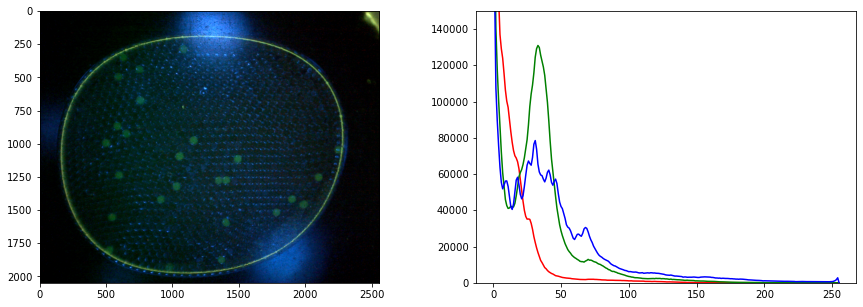

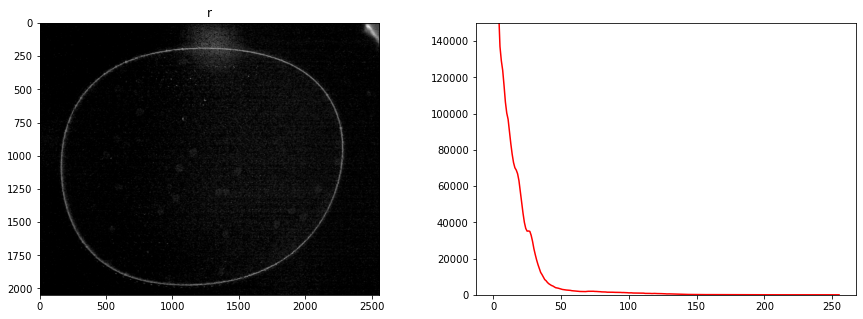

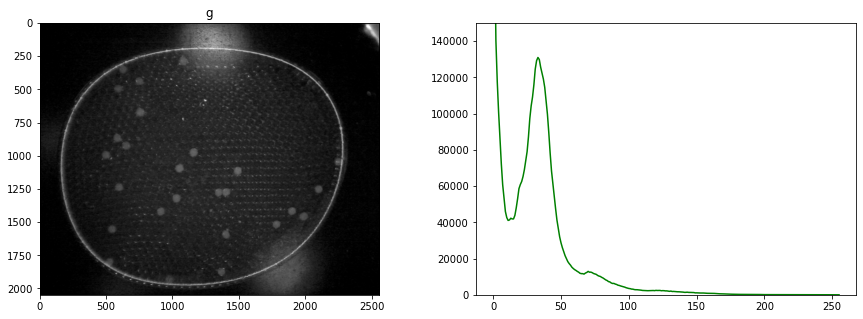

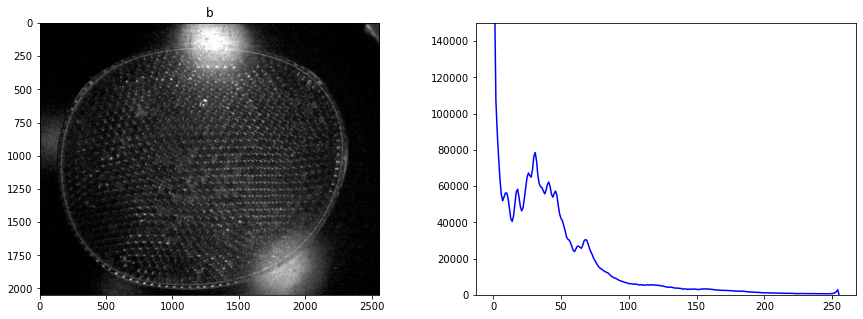

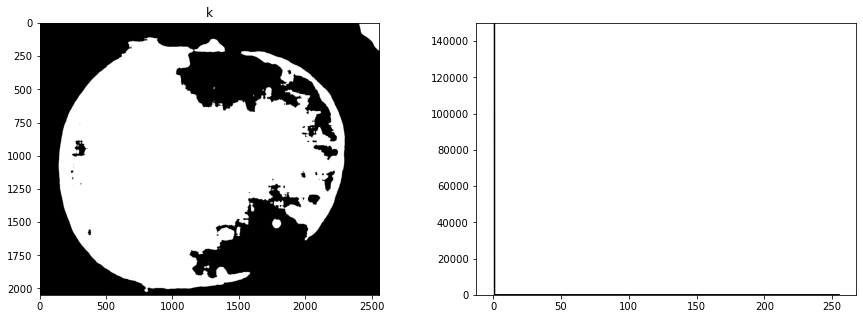

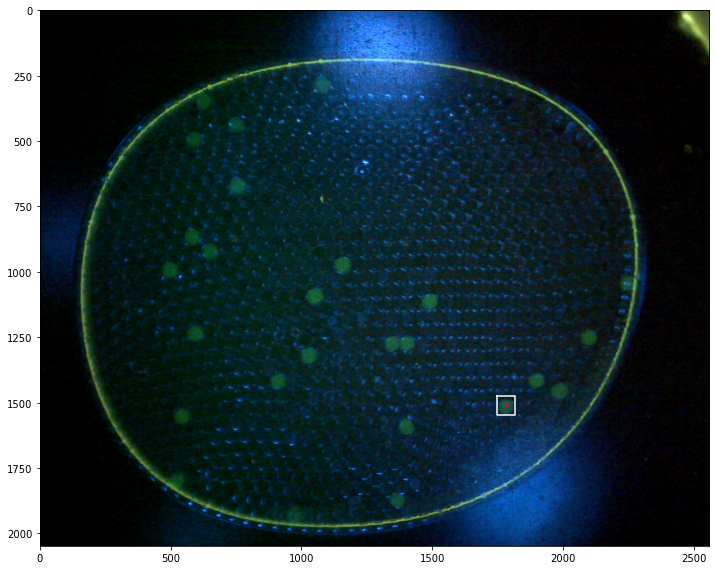

In [106]:
# TESTING

# create labeler instance
labeler = ParticleLabeler()

# read image file
labeler.imread("data/25-miniM.tif")

# display image and histogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
labeler.imshow(ax[0])
labeler.display_histogram(ax[1])
ax[1].set_ylim(0, 150000)

# make composite channel
labeler.composite({'g':1, 'b':-0.53}, 'k')

# threshold
labeler.threshold(src='k', dst='k')

# label
labeler.label(src='k')
print(labeler.particle_count)

# display all channels
for color, channel in labeler.channels.items():
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    channel.imshow(ax[0], color)
    channel.display_histogram(ax[1], color=color)
    ax[1].set_ylim(0, 150000)
    
fix, ax = plt.subplots(1, 1, figsize=(12,10))
labeler.imshow(ax)
for p in labeler.particles:
    if p.size() > 50 and p.size() < 150:
        x, y = p.bounding_box()
        ax.plot(x, y, 'w')
        ax.plot([p.x], [p.y], 'r.', ms=5)

## Demonstrations

46


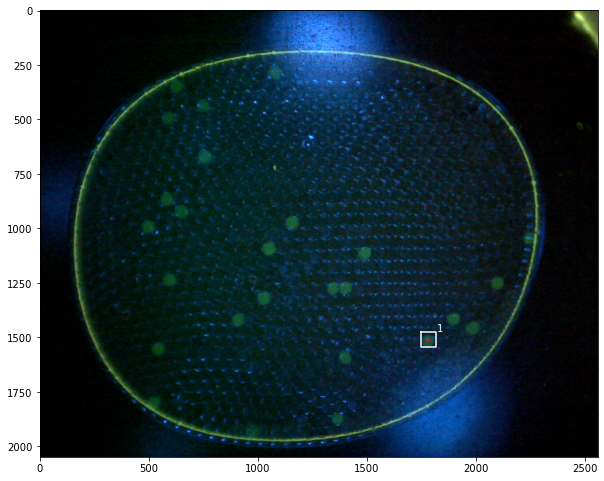

In [107]:
labeler = ParticleLabeler()
labeler.find_particles("data/25-miniM.tif", size=(50, 150))
print(labeler.particle_count)

Text(0.5, 1.0, 'Threshold = 80.0')

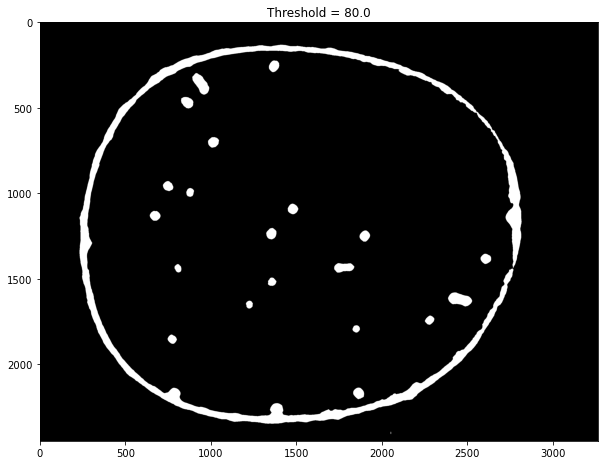

In [113]:
img = labeler.channels['g'].img
fimg = cv.GaussianBlur(img, (71, 71), 0)
fimg = cv.medianBlur(img, 51)
T, timg = cv.threshold(fimg, 80, 255, cv.THRESH_BINARY)
#T, timg = cv.threshold(fimg, 0, 255, cv.THRESH_OTSU)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))
#ax.imshow(img, cmap="gray")
#ax.imshow(img, cmap="gray")
ax.imshow(timg, cmap="gray")
ax.set_title(f"Threshold = {T}")
#ax.imshow(edges, cmap="hot", alpha=0.8)

34


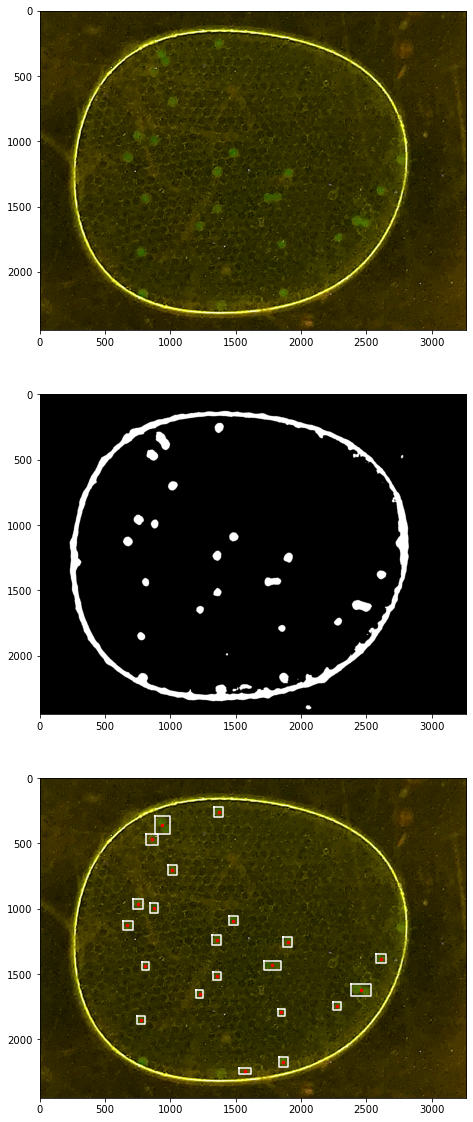

In [120]:
# TESTING

# create labeler instance
labeler = ParticleLabeler()

# read image file
labeler.imread("data/25-camera.jpg")

# make composite channel
labeler.composite({'g':1}, 'k')

# threshold
labeler.threshold(src='k', dst='k', r=41)

# label
labeler.label(src='k')
print(labeler.particle_count)

    
fix, ax = plt.subplots(3, 1, figsize=(12,20))
labeler.imshow(ax[0])
labeler.channels['k'].imshow(ax[1])
labeler.imshow(ax[2])
for p in labeler.particles:
    if p.size() > 50 and p.size() < 150:
        x, y = p.bounding_box()
        ax[2].plot(x, y, 'w')
        ax[2].plot([p.x], [p.y], 'r.', ms=5)

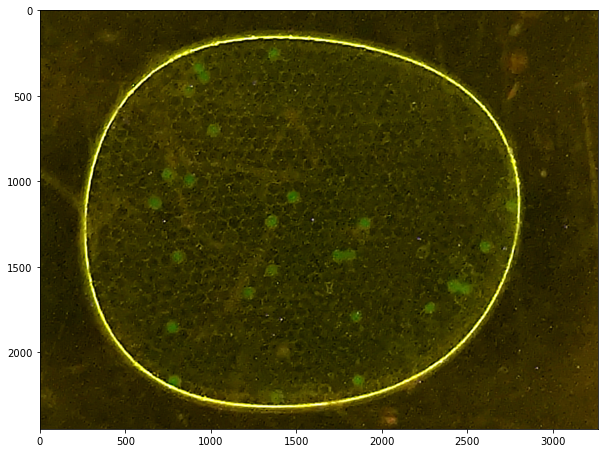

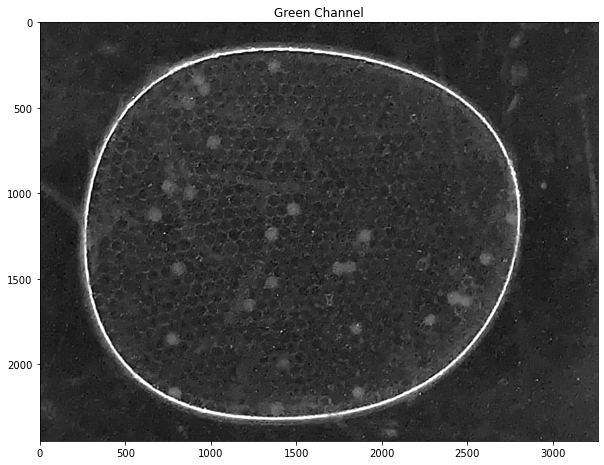

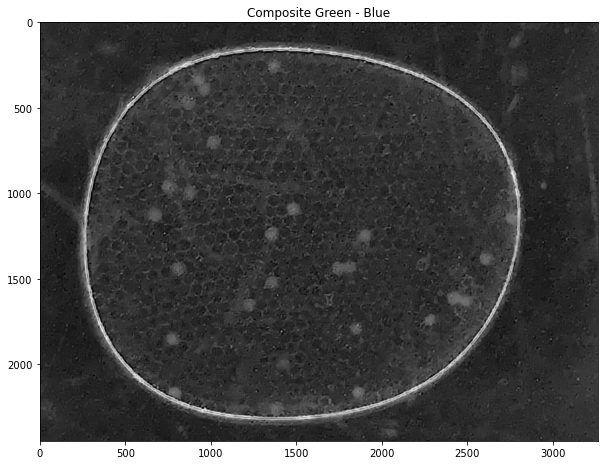

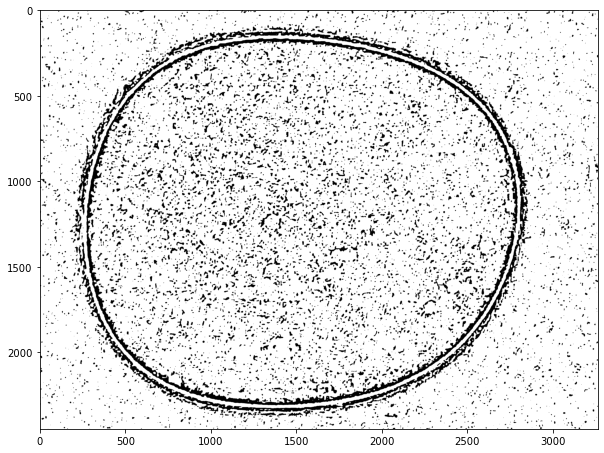

In [108]:
labeler = ParticleLabeler()
labeler.imread("data/25-camera.jpg")
labeler.imshow()
labeler.channels['g'].imshow(title="Green Channel")
labeler.composite({'g':1, 'b':-0.53}, 'k')
labeler.channels['k'].imshow(title="Composite Green - Blue")
labeler.adaptive_threshold(src='g', dst='k2')
labeler.channels['k2'].imshow()

### Thresholding

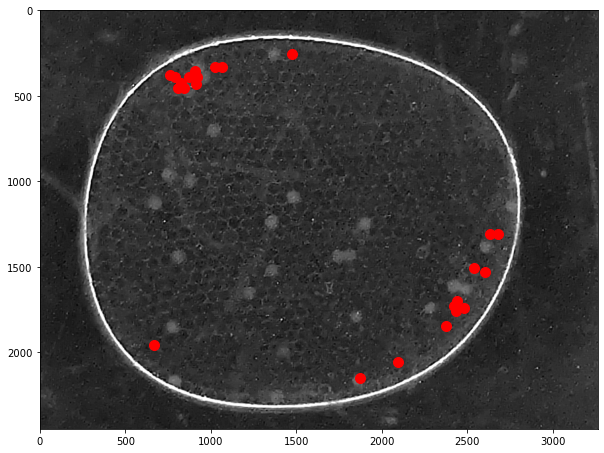

In [110]:
circles = cv.HoughCircles(timg, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          30, 
                          param1=80, 
                          param2=20, 
                          minRadius=50, 
                          maxRadius=200)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.imshow(img, cmap="gray")

for circle in circles[0]:
    x, y, r = circle
    plt.plot([x], [y], 'r.', ms=20)
    